In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

from itertools import chain
import shapely.vectorized as sv

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_statistic as ART_sta
from function import ART_downscale as ART_down

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [ ]:
# correction, nameout, label = 'Linear-Regression', 'LRc', 'Linear Regression'
correction, nameout, label = 'Quantile-Quantile', 'QQc', 'Quantile Quantile Mapping'

In [3]:
COMPUTERNAME = os.environ['COMPUTERNAME']
    # print(f'Computer     : {COMPUTERNAME}')

if COMPUTERNAME == 'BR_DELL':
    dir_font = os.path.join('/','run')
else:
    dir_font = os.path.join('/')

veneto_dir = os.path.join(dir_font,'media','arturo','T9','Data','shapes','Europa','Italy')

# ==================================================================================================
# LOAD ITALY SHAPEFILE
if os.path.exists(veneto_dir):
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

obs_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC')
weibul_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC','Weibull','1dy')

sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')
# ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_ENSEMBLE')

# ==================================================================================================
# READ OBS METADATA
METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)

In [4]:
def get_parameters(product, dir_base, val_max=1.1, corrected=False, corr_method=None):
    # The list bellow is the rain gauges with suspect data
    list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

    if corrected == True:
        if corr_method == 'QQc':
            print(f"Loading {product} corrected statistics...")
            hdf5_file = os.path.join(dir_base,'statistics','QQc',f'statistics_obs_{product}_corrected_{corr_method}.h5')
        else:
            raise ValueError("corr_method must be specified between 'QQc' or 'LRC' when corrected=True")
    else:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}.h5')
    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_WEIBULL = [k for k in keys if k.endswith("/WEIBULL")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]

    stations = []
    lats, lons, elevs = [], [], []
    Nobs, Cobs, Wobs = [], [], []
    Ndown, Cdown, Wdown = [], [], []
    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            continue
        else:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            Nobs_ = data[keys_WEIBULL[nn]].N_obs.values
            Cobs_ = data[keys_WEIBULL[nn]].C_obs.values
            Wobs_ = data[keys_WEIBULL[nn]].W_obs.values
            Ndown_ = data[keys_WEIBULL[nn]].N_down.values
            Cdown_ = data[keys_WEIBULL[nn]].C_down.values
            Wdown_ = data[keys_WEIBULL[nn]].W_down.values

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            Nobs.append(Nobs_)
            Cobs.append(Cobs_)
            Wobs.append(Wobs_)
            Ndown.append(Ndown_)
            Cdown.append(Cdown_)
            Wdown.append(Wdown_)

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'NOBS':Nobs, 'COBS':Cobs, 'WOBS':Wobs, 'NDOWN':Ndown, 'CDOWN':Cdown, 'WDOWN':Wdown})

    return DF_DATA

def linear_regression(OBS, DOWN):
    
    OBS = np.array(OBS)
    DOWN = np.array(DOWN)

    mask = ~np.isnan(OBS) & ~np.isnan(DOWN)
    obs_clean = OBS[mask].reshape(-1, 1) 
    down_clean = DOWN[mask]

    reg = LinearRegression()
    reg.fit(obs_clean, down_clean)

    slope = reg.coef_[0]
    intercept = reg.intercept_

    x_line = np.linspace(np.min(obs_clean), np.max(obs_clean), 100).reshape(-1, 1)
    y_line = reg.predict(x_line)
    
    return slope, intercept, x_line, y_line

def linear_regression_correction(product, time_reso):

    N_Slope, N_intercept, _, _ = linear_regression(globals()[f'DF_{product}'].NOBS.values, globals()[f'DF_{product}'].NDOWN.values)
    C_Slope, C_intercept, _, _ = linear_regression(globals()[f'DF_{product}'].COBS.values, globals()[f'DF_{product}'].CDOWN.values)
    W_Slope, W_intercept, _, _ = linear_regression(globals()[f'DF_{product}'].WOBS.values, globals()[f'DF_{product}'].WDOWN.values)

    dir_in = os.path.join(sat_base, f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')
    DATA = xr.open_dataset(dir_in)

    lats = DATA.lat
    lons = DATA.lon
    lon2d, lat2d = np.meshgrid(lons, lats)

    italy_geom = ITALY.union_all() # ONLY FOR ITALY
    mask_italy = sv.contains(italy_geom, lon2d, lat2d)

    NYd = DATA.NYd.where(mask_italy)[3,:,:].values
    CYd = DATA.CYd.where(mask_italy)[3,:,:].values
    WYd = DATA.WYd.where(mask_italy)[3,:,:].values

    original_shape = NYd.shape
    mask = ~np.isnan(NYd)
    NYd_clear = NYd[mask]
    NYd_corrected_1d = N_Slope * NYd_clear + N_intercept
    NYd_corrected_2d = np.full(original_shape, np.nan)
    NYd_corrected_2d[mask] = NYd_corrected_1d

    original_shape = CYd.shape
    mask = ~np.isnan(CYd)
    CYd_clear = CYd[mask]
    CYd_corrected_1d = C_Slope * CYd_clear + C_intercept
    CYd_corrected_2d = np.full(original_shape, np.nan)
    CYd_corrected_2d[mask] = CYd_corrected_1d

    original_shape = WYd.shape
    mask = ~np.isnan(WYd)
    WYd_clear = WYd[mask]
    WYd_corrected_1d = W_Slope * WYd_clear + W_intercept
    WYd_corrected_2d = np.full(original_shape, np.nan)
    WYd_corrected_2d[mask] = WYd_corrected_1d

    return NYd_corrected_2d, CYd_corrected_2d, WYd_corrected_2d

In [5]:
dir_ = os.path.join('/','media','arturo','T9','Data','Italy')
DF_IMERG = get_parameters('IMERG',dir_)
DF_CMORPH = get_parameters('CMORPH',dir_)

In [6]:
DF_INPUT = DF_IMERG.copy()

In [7]:
remove_list = []
for nn in range(len(DF_INPUT)):
    val_ = DF_INPUT.WOBS[nn].max()
    if val_ > 2:
        remove_list.append(DF_INPUT.STATION[nn])

In [8]:
frac = 0.7
seed = 7

METADATA = METADATA[~METADATA['File'].isin(remove_list)].reset_index(drop=True)
METADATA_CLEAR = METADATA[METADATA['File'].isin(DF_INPUT['STATION'])].reset_index(drop=True)

Q_train_list = []
Q_val_list = []

for iso in METADATA_CLEAR['ISO'].unique():

    META_iso = METADATA_CLEAR[METADATA_CLEAR['ISO'] == iso]

    # Si una región tiene muy pocas estaciones, evita errores
    if len(META_iso) < 2:
        Q_train_list.append(META_iso)
        continue

    META_80 = META_iso.sample(frac=frac, random_state=seed)
    META_20 = META_iso.drop(META_80.index)

    Q_train_list.append(META_80)
    Q_val_list.append(META_20)

Q_train = pd.concat(Q_train_list, ignore_index=True)
Q_val = pd.concat(Q_val_list, ignore_index=True)
list_train = Q_train.File.values

In [9]:
DF_train = DF_INPUT[DF_INPUT['STATION'].isin(Q_train['File'])].reset_index(drop=True)

DF_NOBS = list(chain.from_iterable(DF_train['NOBS']))
DF_COBS = list(chain.from_iterable(DF_train['COBS']))
DF_WOBS = list(chain.from_iterable(DF_train['WOBS']))
DF_NDOWN = list(chain.from_iterable(DF_train['NDOWN']))
DF_CDOWN = list(chain.from_iterable(DF_train['CDOWN']))
DF_WDOWN = list(chain.from_iterable(DF_train['WDOWN']))

In [10]:
Nslope, Nintercept, Nx_line, Ny_line = linear_regression(DF_NOBS, DF_NDOWN)
Cslope, Cintercept, Cx_line, Cy_line = linear_regression(DF_COBS, DF_CDOWN)
Wslope, Wintercept, Wx_line, Wy_line = linear_regression(DF_WOBS, DF_WDOWN)

Text(0.0, 1.0, '(c) Shape')

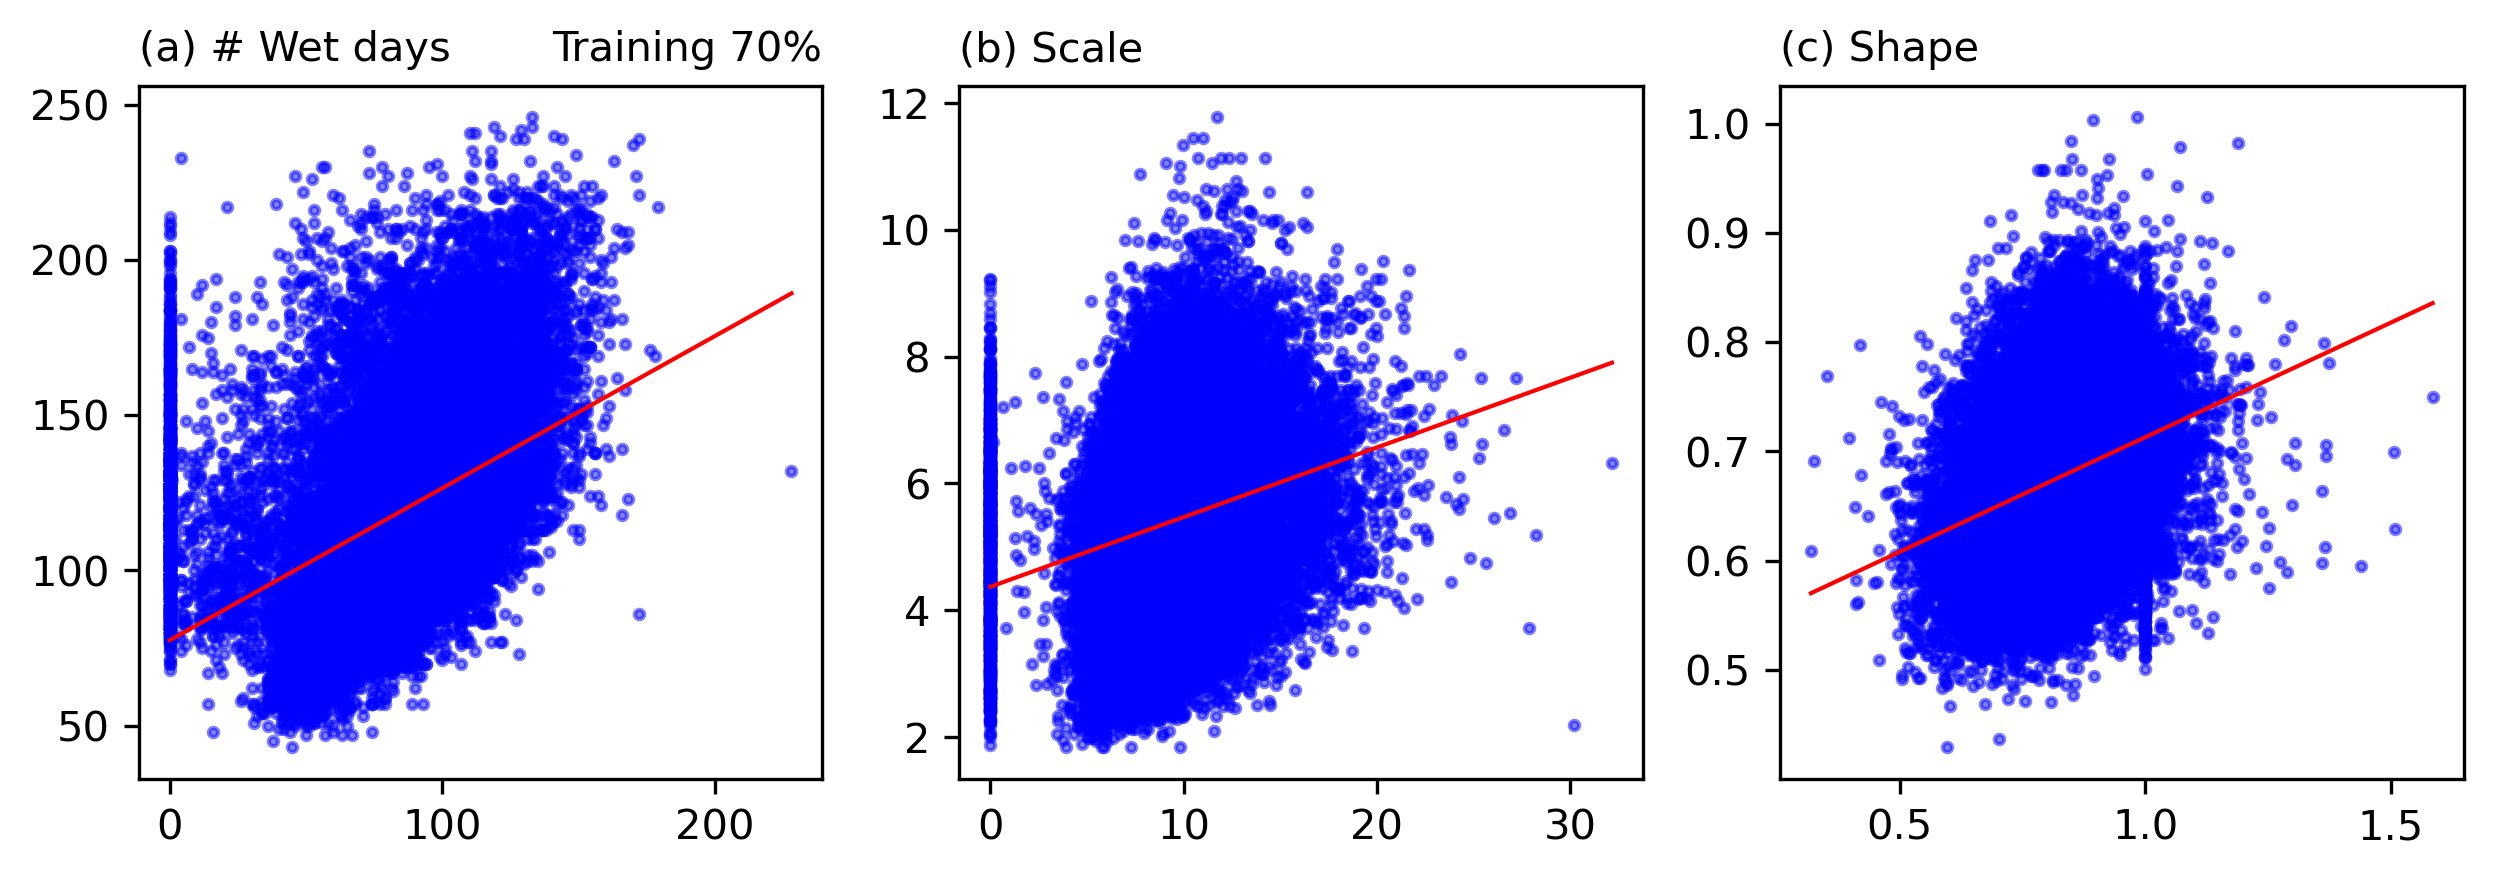

In [11]:
fig = plt.figure(figsize=(10,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# =============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(DF_NOBS, DF_NDOWN, color='blue', s=5, alpha=0.5)
ax1.plot(Nx_line, Ny_line, color='red', linewidth=1)
ax1.set_title('(a) # Wet days ', loc='left',fontsize=10)
ax1.set_title('Training 70%', loc='right',fontsize=10)

# =============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(DF_COBS, DF_CDOWN, color='blue', s=5, alpha=0.5)
ax1.plot(Cx_line, Cy_line, color='red', linewidth=1)
ax1.set_title('(b) Scale', loc='left',fontsize=10)

# =============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(DF_WOBS, DF_WDOWN, color='blue', s=5, alpha=0.5)
ax1.plot(Wx_line, Wy_line, color='red', linewidth=1)
ax1.set_title('(c) Shape', loc='left',fontsize=10)

In [65]:
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'CHIRPS', '1dy'
product, time_reso = 'GSMaP', '3h'

In [66]:
dir_in = os.path.join(sat_base, f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')
DATA = xr.open_dataset(dir_in)

lats = DATA.lat
lons = DATA.lon
lon2d, lat2d = np.meshgrid(lons, lats)

italy_geom = ITALY.union_all() # ONLY FOR ITALY
mask_italy = sv.contains(italy_geom, lon2d, lat2d)

Sat_year = DATA.year.values

if product == 'CHIRPS':
    DATA['NYs'] = DATA.NYs.where(DATA.NYs != 0)
    DATA['CYs'] = DATA.CYs.where(DATA.CYs != 0)
    DATA['WYs'] = DATA.WYs.where(DATA.WYs != 0)
    
    DATA['NYd'] = DATA.NYd.where(DATA.NYd != 0)
    DATA['CYd'] = DATA.CYd.where(DATA.CYd != 0)
    DATA['WYd'] = DATA.WYd.where(DATA.WYd != 0)

NYd = DATA.NYd.where(mask_italy).values
CYd = DATA.CYd.where(mask_italy).values
WYd = DATA.WYd.where(mask_italy).values

mask_italy = sv.contains(italy_geom, lon2d, lat2d)
MEVd_CM_clear = DATA.Mev_d.where(mask_italy)

In [ ]:
if nameout == 'LR':
    original_shape = NYd.shape
    mask = ~np.isnan(NYd)
    NYd_clear = NYd[mask]
    NYd_corrected_1d = Nslope * NYd_clear + Nintercept
    NYd_corrected_2d = np.full(original_shape, np.nan)
    NYd_corrected_2d[mask] = NYd_corrected_1d

    original_shape = CYd.shape
    mask = ~np.isnan(CYd)
    CYd_clear = CYd[mask]
    CYd_corrected_1d = Cslope * CYd_clear + Cintercept
    CYd_corrected_2d = np.full(original_shape, np.nan)
    CYd_corrected_2d[mask] = CYd_corrected_1d

    original_shape = WYd.shape
    mask = ~np.isnan(WYd)
    WYd_clear = WYd[mask]
    WYd_corrected_1d = Wslope * WYd_clear + Wintercept
    WYd_corrected_2d = np.full(original_shape, np.nan)
    WYd_corrected_2d[mask] = WYd_corrected_1d

elif nameout == 'QQc':
    mask = ~np.isnan(NYd)
    NYs_valid = NYd[mask]
    NYs_full = ART_sta.ISIMIP_QM_ALL(DF_NOBS, NYs_valid)
    NYd_corrected_2d = np.full(NYd.shape, np.nan)
    NYd_corrected_2d[mask] = NYs_full

    mask = ~np.isnan(CYd)
    CYs_valid = CYd[mask]
    CYs_full = ART_sta.ISIMIP_QM_ALL(DF_COBS, CYs_valid)
    CYd_corrected_2d = np.full(CYd.shape, np.nan)
    CYd_corrected_2d[mask] = CYs_full

    mask = ~np.isnan(WYd)
    WYs_valid = WYd[mask]
    WYs_full = ART_sta.ISIMIP_QM_ALL(DF_WOBS, WYs_valid)
    WYd_corrected_2d = np.full(WYd.shape, np.nan)
    WYd_corrected_2d[mask] = WYs_full

In [68]:
Tr = [5,  10,  20,  50, 100, 200]
Mevd_corrected = ART_down.pre_quantiles_array(
                            NYd_corrected_2d, 
                            CYd_corrected_2d, 
                            WYd_corrected_2d, 
                            Tr, lats, lons, 1)

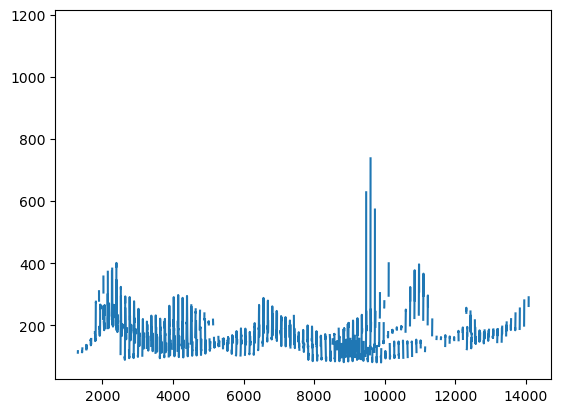

In [69]:
plt.plot(Mevd_corrected[3,:,:].flatten())

In [70]:
Mevd_corrected[3,:,:] = np.where(Mevd_corrected[3,:,:]>350, 350, Mevd_corrected[3,:,:])

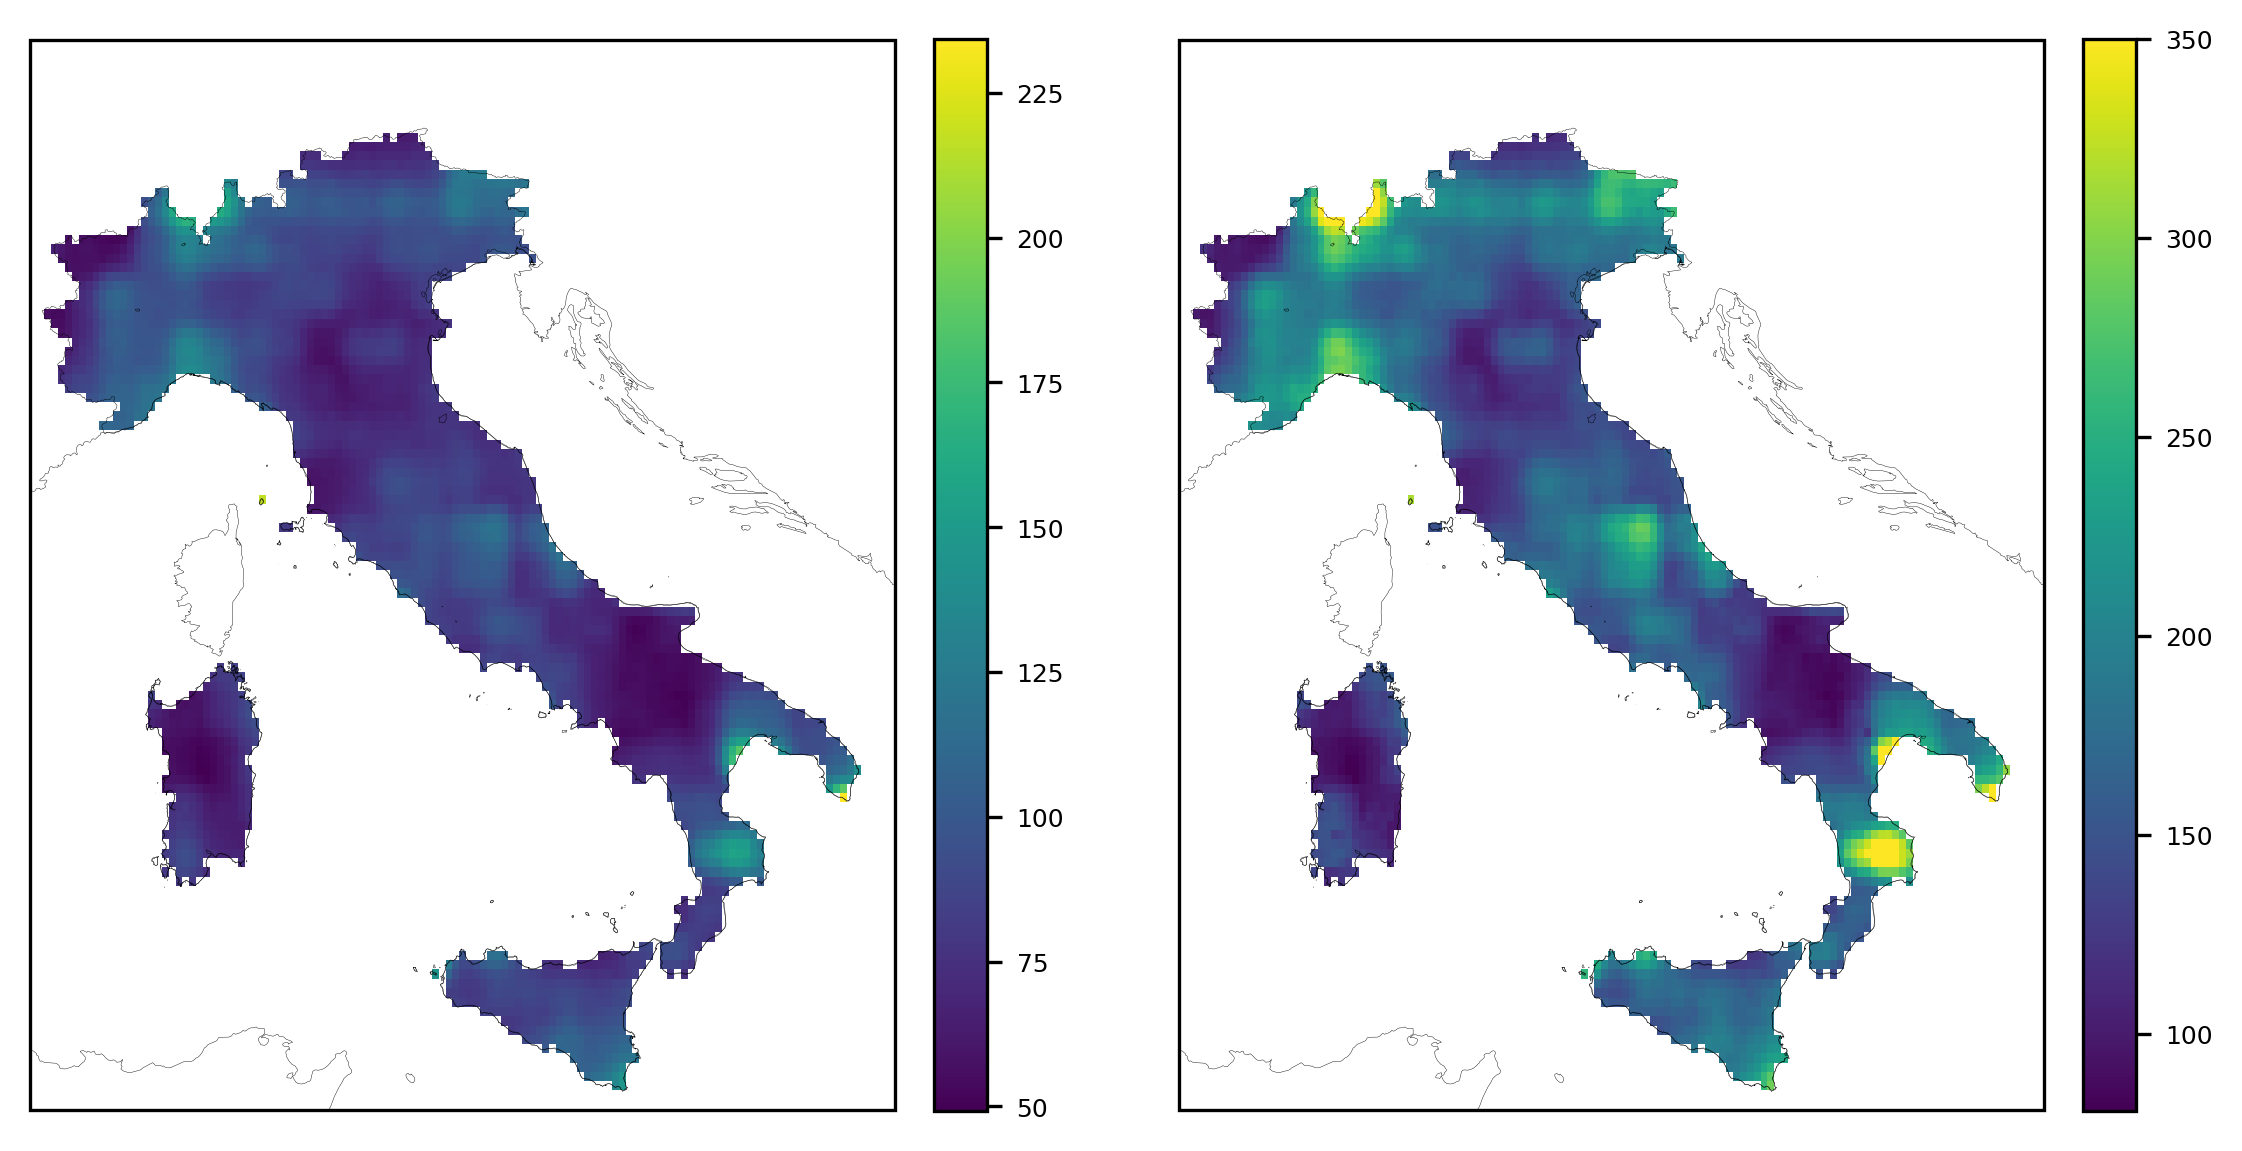

In [71]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(14,9),dpi=300)
gs = gridspec.GridSpec(1,3)

# ========================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
ITALY.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_CM_clear[3,:,:])
cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04)
cbar.ax.tick_params(labelsize=6) 

# ========================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
ITALY.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, Mevd_corrected[3,:,:])
cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04)
cbar.ax.tick_params(labelsize=6) 

In [73]:
DOWN_corrected = xr.Dataset(
    data_vars={
        "NYd": (("year","lat","lon"), NYd_corrected_2d),
        "CYd": (("year","lat","lon"), CYd_corrected_2d),
        "WYd": (("year","lat","lon"), WYd_corrected_2d),
        "Mev_d": (("Tr","lat","lon"), Mevd_corrected),
        },
    coords={
        'year': Sat_year, 
        'lat': lats, 
        'lon': lons
        },
        attrs=dict(description=f"{product} Weibull parameters and MEV corrected applying QQc method using 70% of stations in Italy",))

DOWN_corrected.NYd.attrs["units"] = "# days"
DOWN_corrected.NYd.attrs["long_name"] = "Corrected Downscaled Number of Wet Days"
DOWN_corrected.NYd.attrs["origname"] = "Down Wet Days"

DOWN_corrected.CYd.attrs["units"] = "nondimensional"
DOWN_corrected.CYd.attrs["long_name"] = "Corrected Downscaled Scale Parameter"
DOWN_corrected.CYd.attrs["origname"] = "Down Scale"

DOWN_corrected.WYd.attrs["units"] = "nondimensional"
DOWN_corrected.WYd.attrs["long_name"] = "Corrected Downscaled Shape Parameter"
DOWN_corrected.WYd.attrs["origname"] = "Down Shape"

DOWN_corrected.Mev_d.attrs["units"] = "mm/day"
DOWN_corrected.Mev_d.attrs["long_name"] = "Corrected Downscaled Extreme Quantiles"
DOWN_corrected.Mev_d.attrs["origname"] = "Down Ext-Quant"

DOWN_corrected.lat.attrs["units"] = "degrees_north"
DOWN_corrected.lat.attrs["long_name"] = "Latitude"

DOWN_corrected.lon.attrs["units"] = "degrees_east"
DOWN_corrected.lon.attrs["long_name"] = "Longitude"

# EXPORT AS NETCDF
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')
PRE_out = os.path.join(os.path.join(dir_base, '6_DOWN_BCorrected','TEST', dir_in.split('/')[-1].replace('_pearson',f'_pearson_{nameout}')))
print(f'Exportin as: {PRE_out.split('/')[-1]}')
DOWN_corrected.to_netcdf(PRE_out)

Exportin as: ITALY_DOWN_GSMaP_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_LRc.nc
